In [1]:
from torchvision import models
import torch.nn as nn
from torchvision.models.feature_extraction import get_graph_node_names
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from dataset import CustomImageSet
from sklearn.model_selection import train_test_split
from plots import plot_features
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
cuda = torch.device("cuda")

In [3]:
vgg16_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
test_path = "C:/Users/voicu/OneDrive/Desktop/licenta/OCT2017/test"

test_dataset = CustomImageSet(test_path, transform=vgg16_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
# loading the model
vgg16_features = models.vgg16()
vgg16_features.classifier[-1] = nn.Linear(4096, 4)
vgg16_features.load_state_dict(torch.load("models/vgg16_fine_tuning.pth"))
vgg16_features.to(cuda)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
train_nodes, eval_nodes = get_graph_node_names(vgg16_features)

In [7]:
print(train_nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


In [8]:
embeds = {}


def get_activation(name):
    def hook(model, input, output):
        embeds[name] = output

    return hook

In [9]:
conv_layer = vgg16_features.features[28]
hook_conv = conv_layer.register_forward_hook(get_activation('features.28'))

In [10]:
def extract_conv_features(dataloader, model, layer):
    model.eval()
    features = []
    labels_list = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(cuda)
            labels = labels.to(cuda)

            _ = model(images)

            features.append(embeds[layer].cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels_list)
    return features, labels

In [11]:
conv_features, conv_labels = extract_conv_features(test_dataloader, vgg16_features, 'features.28')
hook_conv.remove()

In [12]:
print(f"Convolutional Features shape: {conv_features.shape}")
print(f"Convolutional Labels shape: {conv_labels.shape}")

Convolutional Features shape: (3400, 512, 14, 14)
Convolutional Labels shape: (3400,)


In [13]:
# KMeans expects 2D array - samples, features
# flatten features
conv_features = conv_features.reshape(conv_features.shape[0], -1)
print(f"Convolutional Features shape: {conv_features.shape}")

Convolutional Features shape: (3400, 100352)


In [14]:
n_clusters = 4

kmeans_conv4 = KMeans(n_clusters=n_clusters, random_state=42).fit(conv_features)
conv_labels4 = kmeans_conv4.predict(conv_features)
conv_centroids4 = kmeans_conv4.cluster_centers_

In [15]:
def KMeansMetrics(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    print(classification_report(y_test, y_pred))

    acc = accuracy_score(y_pred, y_test)
    print(f'Accuracy: {acc}')

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       397
           1       0.95      0.91      0.93        88
           2       0.99      0.84      0.91        95
           3       1.00      0.73      0.84       100

    accuracy                           0.92       680
   macro avg       0.96      0.87      0.91       680
weighted avg       0.93      0.92      0.92       680

Accuracy: 0.9205882352941176


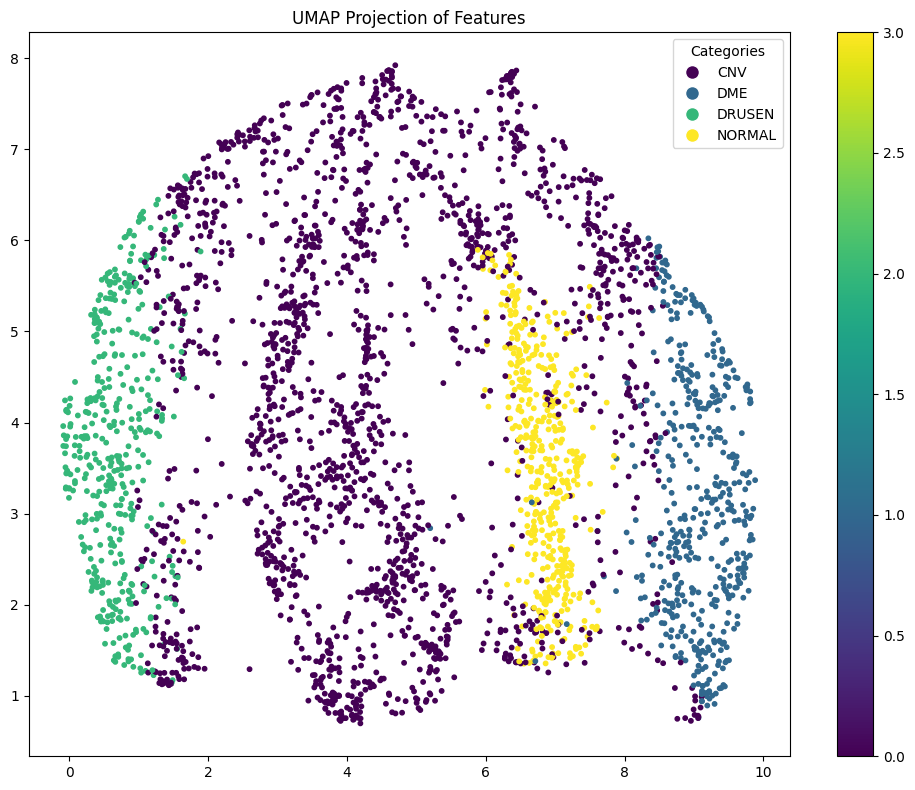

In [16]:
KMeansMetrics(conv_features, conv_labels4)
plot_features(conv_features, conv_labels4)

In [17]:
pooling_layer = vgg16_features.avgpool
hook_pooling = pooling_layer.register_forward_hook(get_activation('avgpool'))

In [18]:
pooling_features, pooling_labels = extract_conv_features(test_dataloader, vgg16_features, 'avgpool')
hook_pooling.remove()

In [19]:
print(f"Average Pooling Features shape: {pooling_features.shape}")
print(f"Average Pooling Labels shape: {pooling_features.shape}")

Average Pooling Features shape: (3400, 512, 7, 7)
Average Pooling Labels shape: (3400, 512, 7, 7)


In [20]:
# KMeans expects 2D array - samples, features
# flatten features
pooling_features = pooling_features.reshape(pooling_features.shape[0], -1)
print(f"Average Pooling Features shape: {pooling_features.shape}")

Average Pooling Features shape: (3400, 25088)


In [21]:
n_clusters = 4

kmeans_pooling4 = KMeans(n_clusters=n_clusters, random_state=42).fit(pooling_features)
pooling_labels4 = kmeans_pooling4.predict(pooling_features)
pooling_centroids4 = kmeans_pooling4.cluster_centers_

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       378
           1       0.99      0.85      0.91        91
           2       0.93      0.93      0.93       107
           3       1.00      0.80      0.89       104

    accuracy                           0.93       680
   macro avg       0.95      0.89      0.92       680
weighted avg       0.93      0.93      0.93       680

Accuracy: 0.9264705882352942


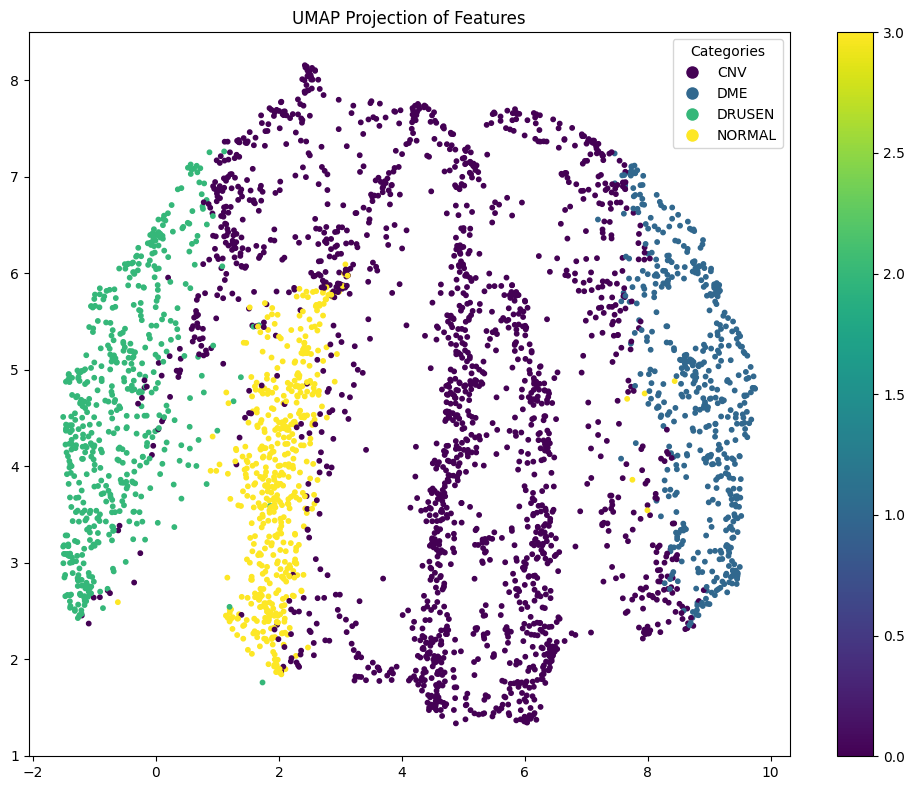

In [22]:
KMeansMetrics(pooling_features, pooling_labels4)
plot_features(pooling_features, pooling_labels4)